  Four structuring elements (B1, B2, B3, B4) and a background element (Bg) are defined. Structuring elements are small matrices that are used in morphological operations to analyze and manipulate the shapes and structures within an image. These elements will be employed to iteratively shape the binary image to reveal its convex hull. The binary image represents an object or a set of objects in the form of pixels, where 1 indicates the presence of an object, and 0 indicates its absence. The convex hull is the smallest convex shape that completely encloses the object(s). The process begins by designing the necessary functions that will be utilized by the convex_hull function, such as hit-or-miss function, thickening, union, intersect operations. Also the erosion function that will be used by ‘hit-or-miss’ operation is implemented. These operations use the defined structuring elements (B1, B2, B3, B4, Bg) to iteratively modify the binary image, highlighting convex features. The result is a binary image representing the convex hull.









In [2]:
# Upload the image to Colab

from google.colab import files
uploaded = files.upload()


Saving perfectly_painted_cat.png to perfectly_painted_cat.png


In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import pylab

Image height= 400 px, and width= 400 px and data type: uint8


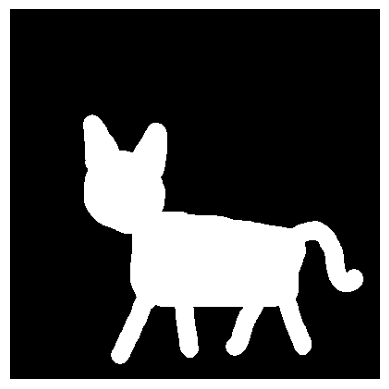

In [4]:
# Read the image in grayscale mode using OpenCV library
input = cv2.imread('perfectly_painted_cat.png', cv2.IMREAD_GRAYSCALE)

# Get the height and width of the image
height, width = input.shape

# Apply thresholding to create a binary image
_, image = cv2.threshold(input, 128, 1, cv2.THRESH_BINARY)

# Print information about the image
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

# Display the binary image using Matplotlib
plt.imshow(image,'gray')
plt.axis('off')
plt.show()

In [6]:
# Define 4 3x3 binary matrixes that will be used as SE and 1 matrix that represents background

B1 = np.array([[1, 0, 0],
              [1, 0, 0],
              [1, 0, 0]])

B2 = np.array([[1, 1, 1],
              [0, 0, 0],
              [0, 0, 0]])

B3 = np.array([[0, 0, 1],
              [0, 0, 1],
              [0, 0, 1]])

B4 = np.array([[0, 0, 0],
              [0, 0, 0],
              [1, 1, 1]])

Bg = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])


In [7]:
def erosion(image, se):
  # Create an array of zeros with the same shape as the input image
  result = np.zeros_like(image)

  # Get the number of rows and columns in the structuring element (se)
  se_rows, se_cols = se.shape

  # Get the number of rows and columns in the input image
  img_rows, img_cols = image.shape

  # Iterate the SE over the input image
  for row in range(img_rows - se_rows + 1):
      for col in range(img_cols - se_cols + 1):

        # Extract the region of interest from the input image
          region = image[row:row + se_rows, col:col + se_cols]

          # Check if the structuring element matches the region
          if np.all(region[se == 1]):
            # If all elements in the region where the structuring element is 1 are 1,
            # set the central pixel in the result image to 1
            result[row + se_rows // 2, col + se_cols // 2] = 1

  # Return the result of erosion
  return result



In [8]:
def hit_or_miss(image, Bi, Bg):
  # Perform erosion on the input image with structuring element Bi
    erosion_bi = erosion(image,Bi)

    # Perform erosion on the complement of the input image with structuring element Bg
    erosion_bg = erosion(~image,Bg)

    # Use logical AND to combine the results of the two erosions
    result = np.logical_and(erosion_bi.astype(bool), erosion_bg.astype(bool)).astype(int)

    # Return the result of the hit-or-miss operation
    return result

In [9]:
def thickening(hitmissresult, image):
  # Use logical OR to combine the hit-or-miss result and the original image
    result = np.logical_or(hitmissresult.astype(bool), image.astype(bool)).astype(int)

    # Return the result of thickening
    return result



In [10]:
def union(image1, image2):
  # Use logical OR to combine the two input images
    result = np.logical_or(image1.astype(bool), image2.astype(bool)).astype(int)

    # Return the result of the union operation
    return result


In [11]:
def intersection(image1, image2):
   #Use logical AND to find the common pixels between the two input images
    result = np.logical_and(image1.astype(bool), image2.astype(bool)).astype(int)

    # Return the result of the intersection operation
    return result



In [12]:
def convex_loop(image,Bi,Bg):
    # Initialize hit-or-miss result using the input image
    hitmissresult = hit_or_miss(image,Bi,Bg)

    # Initialize thickening using the hit-or-miss result and the original image
    bi_thickening = thickening(image, hitmissresult)

    # Save a copy of the image before thickening for comparison in the loop
    old_bi_thickening = image

    # Iterate until the thickening result no longer changes
    while not np.array_equal(old_bi_thickening, bi_thickening):
        # Update the before thickening  field
        old_bi_thickening = np.copy(bi_thickening)

        # Perform hit-or-miss on the current thickening result
        hitmissresult = hit_or_miss(bi_thickening, Bi, Bg)

        # Update thickening using the new hit-or-miss result
        bi_thickening = thickening(bi_thickening, hitmissresult)

    # Return the final convex hull obtained through iteration
    return bi_thickening




In [13]:
def convex_hull(image,B1,B2,B3,B4,Bg):

    # Compute thickening using convex_loop for each structuring element
    b1_thickening_image=convex_loop(image,B1,Bg)
    b2_thickening_image=convex_loop(image,B2,Bg)
    b3_thickening_image=convex_loop(image,B3,Bg)
    b4_thickening_image=convex_loop(image,B4,Bg)

    # Combine the thickening results using union operations
    union1 = union(b1_thickening_image, b2_thickening_image)
    union2 = union(b3_thickening_image, b4_thickening_image)
    union3 = union(union1, union2)

    # Find the bounding box of the original binary image
    minrow, maxrow = float('inf'), 0
    mincol, maxcol = float('inf'), 0

    # Create a temporary array to store the bounding box
    temp= np.zeros(image.shape)

     # Iterate over each pixel in the original binary image
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
          # If the pixel is part of the object (value is 1)
            if image[row, col] == 1:
                minrow = min(minrow, row)
                maxrow = max(maxrow, row)
                mincol = min(mincol, col)
                maxcol = max(maxcol, col)

    # Set the pixels inside the bounding box to 1 in the temporary array
    temp[minrow:maxrow+1, mincol:maxcol+1] = 1

    # Compute the intersection of the unioned thickening result and the bounding box
    result = intersection(union3, temp)
    return result


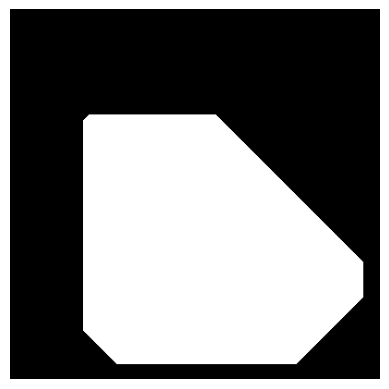

In [14]:
# Obtain the convex hull of the input binary image using specific structuring elements
final_image=convex_hull(image,B1,B2,B3,B4,Bg)
# Display the resulting convex hull using Matplotlib
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.show()